# CMSE 381 Final Project

**INSTRUCTIONS**: This is a template to help organize your project.  All projects should include the 5 major sections below (you do not need to use this template file).  If you use this file, complete your work below and remove content in parentheses. Also, remove this current cell.  

#### CMSE 381 Final Project
### &#9989; Group members: Tyler Wolstone, Sukruth Rao
### &#9989; Section_001
#### &#9989; April 25, 2025

# Analysis of section 001 Dataset : The Brain and its processes. 

## Background and Motivation

In the macaque brain, there’s a spot called the anterior medial (AM) face patch that responds selectively to face stimuli The neurons there fire in different patterns depending on both who the face belongs to and which way it’s turned.  Past studies have tried to decode one of eight possible head orientations from these spike trains, but that multiclass approach often yields only average accuracy. We have simplified this to a binary decision—“front” versus “non-front”—using AM activity recorded during the first 400 ms after stimulus onset. By collecting spikes into coarse time bins, we expect to strengthen the signal that specifically marks head-on views and better reveal how quickly and reliably AM encodes a frontal face.

The questions that we are trying to answer for this project are: 
- Question 1: Can we classify a “front” view versus a “non-front” view of a face solely from AM spike-train data?
- Question 2: Can we use feature engineering to better capture the neural activations across a 400ms window? In detail, can these engineered features help improve the accuracy of classifying 25 different individuals compared to using raw activation timestamps or  dimensionality reduction techniques like PCA?

## Methodology

### Research Question 1:
To answer whether AM activity can distinguish a frontal face from all other orientations, we followed these steps:

- Load and preprocess the spike‐train data
- We combined trials from three recording sites, extracted the first 400 fine‐grained time bins of spiking activity, and built a binary label vector (1 = front, 0 = non-front).
- We then had the counts printed for "non-front" vs. "front" facing views. 
- We held out 20 % of the data for testing, stratifying by the binary label, and trained a Random Forest as a simple baseline.
- To get a clearer measure of performance, we also applied 5-fold cross‐validation on the coarse‐binned data:

### Research Question 2:
To answer question 2, we take the following steps:
- Using simple training and testing, evaluate the models based on their accuracies using all the features except the feature engineered ones.
- Use the features in step 1 to perform K-Fold cross-validation to get the best accuracies and k (fold value) of all the features.
- Using simple training and testing, evaluate the models based on their accuracies using all the features + engineered features
- Use all the features used in step 2 to perform K-Fold cross-validation to get the best accuracies and k (fold value) of all models
- Instead of using the 400 time neural activation features, we use the newly introduced features (activations_0_200, activations_200_400, total_activations, first_activation_time_frame, mean_activations) and repeat step 1.
- Using the features from step 5, repeat step 2.
- Use PCA (Principal Component Analysis) to reduce the number of features (features + added features) to 10 and evaluate the models based on accuracies.
- Use K-Fold to obtain the best number of components and obtain the accuracies of the models along with the optimal number of components.
- Compare the results obtained across step 1 - step 8
- Using the best model obtained through accuracies, find the best hyperparameter for that model and evaluate results.

In [348]:
# you may want to import some modules here

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

### Data

### Research Question 1: 
We use the Freiwald–Tsao Face Views AM dataset, combining recordings from three electrode “sites.” Each trial includes:
Metadata columns
site_info.monkey, site_info.region

labels.stimID  (unique stimulus index)

labels.person  (face identity, 25 levels)

labels.orientation (“front”, “left”, “right”, …; 8 levels)

labels.orient_person_combo (combined identity × orientation)

Spike‐train features

time.1_2, time.2_3, …, time.800_801 (801 columns).

Each entry is 0/1 indicating whether a spike occurred in that 2 ms window.
We are only taking the first 400 of these (0–800 ms range) as our input features.
For our binary “front vs. non‐front” task we get, feature matrix X_raw of shape (n_trials, 400) and label vector y_bin of 0 (non‐front) or 1 (front).

In [350]:
# you may need some code here to adjust the format or organization of your data so that they can be used for the model

import pandas as pd

base = 'freiwald_data/Freiwald_Tsao_faceviews_AM_data_csv'
df = pd.read_csv(f'{base}/raster_data_bert_am_site013.csv')

print("Columns:\n", df.columns.tolist())
print("\nFirst 5 trials:\n", df.head())


Columns:
 ['site_info.monkey', 'site_info.region', 'labels.stimID', 'labels.person', 'labels.orientation', 'labels.orient_person_combo', 'time.1_2', 'time.2_3', 'time.3_4', 'time.4_5', 'time.5_6', 'time.6_7', 'time.7_8', 'time.8_9', 'time.9_10', 'time.10_11', 'time.11_12', 'time.12_13', 'time.13_14', 'time.14_15', 'time.15_16', 'time.16_17', 'time.17_18', 'time.18_19', 'time.19_20', 'time.20_21', 'time.21_22', 'time.22_23', 'time.23_24', 'time.24_25', 'time.25_26', 'time.26_27', 'time.27_28', 'time.28_29', 'time.29_30', 'time.30_31', 'time.31_32', 'time.32_33', 'time.33_34', 'time.34_35', 'time.35_36', 'time.36_37', 'time.37_38', 'time.38_39', 'time.39_40', 'time.40_41', 'time.41_42', 'time.42_43', 'time.43_44', 'time.44_45', 'time.45_46', 'time.46_47', 'time.47_48', 'time.48_49', 'time.49_50', 'time.50_51', 'time.51_52', 'time.52_53', 'time.53_54', 'time.54_55', 'time.55_56', 'time.56_57', 'time.57_58', 'time.58_59', 'time.59_60', 'time.60_61', 'time.61_62', 'time.62_63', 'time.63_64'

In [351]:
# you may want to write some code to see what the data looks like
print(df['labels.orientation'].value_counts())

sites = [
    'raster_data_bert_am_site013.csv',
    'raster_data_bert_am_site014.csv',
    'raster_data_lupo_am_site225.csv'
]

X_list, y_list = [], []
for fname in sites:
    d = pd.read_csv(f'{base}/{fname}')
    time_cols = [c for c in d.columns if c.startswith('time.')][:400]
    X_list.append(d[time_cols].astype(int).values)
    y_list.append((d['labels.orientation']=='front').astype(int).values)

min_trials = min(arr.shape[0] for arr in X_list)
X_list = [arr[:min_trials] for arr in X_list]
y_list = [arr[:min_trials] for arr in y_list]

X_raw = np.vstack(X_list) 
y_bin = np.concatenate(y_list) 

print("Total trials:", X_raw.shape[0])
print("Feature dim:", X_raw.shape[1])
print("Front / Non-front counts:", np.bincount(y_bin))


labels.orientation
right profile    88
down             88
left profile     86
front            85
left 3/4         85
up               85
back             84
right 3/4        83
Name: count, dtype: int64
Total trials: 2052
Feature dim: 400
Front / Non-front counts: [1661  391]


### Research Question 2:

We consider only one dataset from the zip file named 'Freiwald_Tsao_faceviews_AM_data_csv' for this question. Since our goal is to find what model predicts the individuals correctly, our target variable is 'labels.person' (each person viewed by the animal). The rest of the features are used as predictors ('site_info.monkey', 'site_info.region', 'labels.stimID', 'labels.person', 'labels.orientation' 'labels.orient_person_combo', 'time.1_2',... to ... 'time.399_400'). We only consider upto time.399_400, as only 400ms is relevant for the labeled image. We subsequently introduce new features:

- activations_0_200: total number of activations (1) between 0m/s and 200m/s of viewing the image
- activations_200_400: total number of activations (1) between 200m/s and 400m/s
- total_activations: total number of activation for a trial
- first_activation_time_frame: the first neural activation (1) encountered in a specific trial
- mean_activations: the mean number of activations for a trial

These features were created to better capture the neural activations across the entire time frame. The reason for introducing these features was our concern that the model might struggle to learn effectively from the original 405 columns, of which 400 contained data on neural activations across 400 ms, mostly consisting of zeros with very few activations (1s).

In [354]:
# Loading and displaying the dataset
directory_path = "Freiwald_Tsao_faceviews_AM_data_csv"
file_list = os.listdir(directory_path)
data_list = []
count = 0
for file_name in file_list:
    file_path = os.path.join(directory_path, file_name)
    if ".csv" in file_path:
        data_temp = pd.read_csv(file_path)
        data_list.append(data_temp)
        count += 1
    if count == 1:
        break
data = pd.concat(data_list)
print(data.shape)
data.head()

(1600, 806)


,site_info.monkey,site_info.region,labels.stimID,labels.person,labels.orientation,labels.orient_person_combo,time.1_2,time.2_3,time.3_4,time.4_5,...,time.791_792,time.792_793,time.793_794,time.794_795,time.795_796,time.796_797,time.797_798,time.798_799,time.799_800,time.800_801
0,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
data = data.iloc[:, :405] 
data = data.drop(['site_info.region'], axis=1)

time_data = data.iloc[:, 5:]
time_cols = list(data.columns)[5:]

data['activations_0_200'] = data.iloc[:, 5:205].sum(axis=1)
data['activations_200_400'] = data.iloc[:, 205:405].sum(axis=1)
data['total_activations'] = data.iloc[:, 5:405].sum(axis=1)

first_activations = []
for i, row in data.iterrows():
    first_act_col = None
    for col in time_cols:
        if row[col] == 1:
            first_act_col = col
            break
        else:
            first_act_col = 'None'
    first_activations.append(first_act_col)
data['first_activation_time_frame'] = first_activations

data['mean_activations'] = data['total_activations'] / len(time_cols)
data.head()

,site_info.monkey,labels.stimID,labels.person,labels.orientation,labels.orient_person_combo,time.1_2,time.2_3,time.3_4,time.4_5,time.5_6,...,time.395_396,time.396_397,time.397_398,time.398_399,time.399_400,activations_0_200,activations_200_400,total_activations,first_activation_time_frame,mean_activations
0,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,0.000000
1,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,1,1,2,time.157_158,0.005013
2,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,time.369_370,0.002506
3,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,1,1,2,time.165_166,0.005013
4,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,0.000000


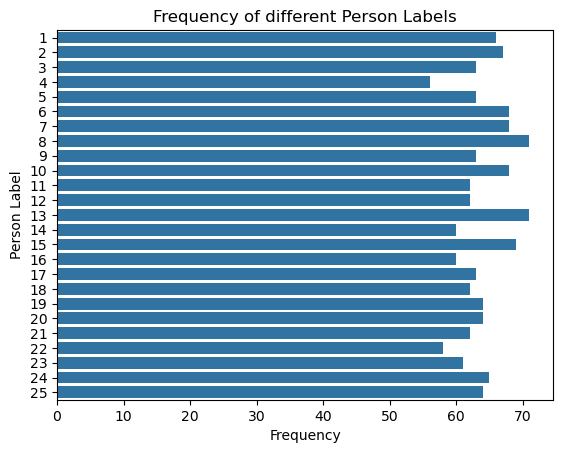

In [356]:
y = data['labels.person']
X = data.drop(['labels.person'], axis=1)

sns.countplot(y=y)
plt.title('Frequency of different Person Labels')
plt.xlabel('Frequency')
plt.ylabel('Person Label')
plt.show()

### Models for classification 
### Research Question 1:

The models that we used for the second question are Random Forest Classifier, we chose this because it can handle binary inputs without feature scaling and it helps to rid overfitting by having many trees. The question that we would answer with it is "Can AM activity reliably distinguish between frontal vs non-frontal views? To evaluate the model, we used a classification report as well as a confusion matrix on the test data. We also used 5-fold CV to estimate the accuracy directly on the features. 

In [358]:
# you may add some code here to show how the model works in principle

clf = RandomForestClassifier(n_estimators=200, max_depth=15,random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [359]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_raw, y_front, cv=cv, scoring='accuracy', n_jobs=-1)
print("5-fold CV scores:", scores)
print("Mean CV accuracy:", scores.mean())

5-fold CV scores: [0.81508516 0.81995134 0.80243902 0.8        0.8097561 ]
Mean CV accuracy: 0.8094463236603169


### Research Question 2

The models we used for this research question are:

- Logistic Regression: The baseline for a classification task.
- KNN (K-Nearest Neighbors): Group data points into different classes by looking at the classes of the data points nearest to them. Its known for its ability to learn non-linear data. However it does struggle with high-dimensional data and requires a lot of computations.
- Random Forest Classifier: Uses bootstrap samples of training data and random subset of features to classify based on majority vote. Generally considered a model that performs well in terms of robustness, accuracy, and its ability to handle complex data.
- AdaBoost: Improves model performance by giving more weightage to misclassified data during training and allows simple models to focus on data points that are difficult for the model to classify correctly. Since the model is complex and consists of hundreds of features, it might be useful in reducing overfitting and improving overall performance.

In [362]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000), 
    'KNN': KNeighborsClassifier(n_neighbors=1),
    'Random Forest Classifier': RandomForestClassifier(random_state=10),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=10, algorithm="SAMME")
}

### Other methods used 
We first use LabelEncoder to convert categorical columns into numerical. We use fit_transform to assigne each different category to a specific number.

In [364]:
# Preprocessing before classification
label_encoder = LabelEncoder()
data = data.apply(label_encoder.fit_transform)
data.head()

,site_info.monkey,labels.stimID,labels.person,labels.orientation,labels.orient_person_combo,time.1_2,time.2_3,time.3_4,time.4_5,time.5_6,...,time.395_396,time.396_397,time.397_398,time.398_399,time.399_400,activations_0_200,activations_200_400,total_activations,first_activation_time_frame,mean_activations
0,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,1,1,2,59,2
2,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,1,1,215,1
3,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,1,1,2,68,2
4,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



We also write several helper functions:
- simple train-test split evaluation for multiple models.
- kfold to obtain best accuracies and k values for multiple models
- kfold to obtain best accuracies and number of components for PCA for multiple models
- loocv to obtain the accuracy for multiple models

Our goal of using the above functions is the compare the performance (accuracies) of different models and methods. In doing so, we ultimately select the best performing model and method based on the results. 

In [366]:
def train_test(models, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

    results = {}
    for i, model in models.items():
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        results[i] = acc

    return results

def perform_KFold(model, X_values, y_values):
    best_acc = -float('inf')
    optimal_k = None  
    acc_lst = []
    
    for i in range(2, 15):  
        kf = KFold(n_splits=i, shuffle=True, random_state=10)
        accs = []
        for train_idx, test_idx in kf.split(X_values):
            X_train, X_test = X_values[train_idx], X_values[test_idx]
            y_train, y_test = y_values[train_idx], y_values[test_idx]
            
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            acc = accuracy_score(y_test, y_hat)
            accs.append(acc)
            
        avg_acc = np.mean(accs)
        acc_lst.append(avg_acc)
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            optimal_k = i

    plt.plot(range(2, 15), acc_lst, marker='o')
    plt.xlabel('Fold (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Folds')
    plt.grid(True)
    plt.show()

    return best_acc, optimal_k

def perform_KFold_PCA(model, X_values, y_values, optimal_k):    
    best_acc = -float('inf')
    optimal_n = None
    acc_lst = []
    
    n_lst = [10, 30, 50, 100, 200]
    
    for n in n_lst:
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X_values)
        kf = KFold(n_splits=optimal_k, shuffle=True, random_state=4)
        accs = []
        
        for train_idx, test_idx in kf.split(X_pca):
            X_train, X_test = X_pca[train_idx], X_pca[test_idx]
            y_train, y_test = y_values[train_idx], y_values[test_idx]
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            acc = accuracy_score(y_test, y_hat)
            accs.append(acc)
            
        avg_acc = np.mean(accs)
        acc_lst.append(avg_acc)
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            optimal_n = n
    
    plt.plot(n_lst, acc_lst, marker='o')
    plt.xlabel('number of components')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Components')
    plt.grid(True)
    plt.show()
    
    return best_acc, optimal_n


def perform_KFold(model, X_values, y_values):
    best_acc = -float('inf')
    optimal_k = None  
    acc_lst = []
    
    for i in range(2, 15):  
        kf = KFold(n_splits=i, shuffle=True, random_state=10)
        accs = []
        for train_idx, test_idx in kf.split(X_values):
            X_train, X_test = X_values[train_idx], X_values[test_idx]
            y_train, y_test = y_values[train_idx], y_values[test_idx]
            
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            acc = accuracy_score(y_test, y_hat)
            accs.append(acc)
            
        avg_acc = np.mean(accs)
        acc_lst.append(avg_acc)
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            optimal_k = i

    plt.plot(range(2, 15), acc_lst, marker='o')
    plt.xlabel('Fold (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Folds')
    plt.grid(True)
    plt.show()

    return best_acc, optimal_k

def perform_LOOCV(model, X_values, y_values):
    lcv = LeaveOneOut() 
    accs = []
    
    for train_idx, test_idx in lcv.split(X_values):
        X_train, X_test = X_values[train_idx], X_values[test_idx]
        y_train, y_test = y_values[train_idx], y_values[test_idx]
        
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_hat)
        accs.append(acc)
        
    avg_acc = np.mean(accs)
    return avg_acc

## Results

### Research Question 1: classification results


In [369]:
import os
base_path = 'freiwald_data/Freiwald_Tsao_faceviews_AM_data_csv'

print("Files in folder:\n", os.listdir(base_path))

import pandas as pd
df = pd.read_csv(f'{base_path}/raster_data_bert_am_site013.csv', nrows=5)
print("\nColumns in raster_data_bert_am_site013.csv:\n", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())

Files in folder:
 ['raster_data_bert_am_site070.csv', 'raster_data_lupo_am_site181.csv', 'raster_data_bert_am_site138.csv', 'raster_data_bert_am_site110.csv', 'raster_data_bert_am_site105.csv', 'raster_data_bert_am_site313.csv', 'raster_data_lupo_am_site157.csv', 'raster_data_bert_am_site065.csv', 'raster_data_lupo_am_site221.csv', 'raster_data_lupo_am_site209.csv', 'raster_data_lupo_am_site223.csv', 'raster_data_bert_am_site073.csv', 'raster_data_lupo_am_site009.csv', 'raster_data_lupo_am_site021.csv', 'raster_data_bert_am_site265.csv', 'raster_data_lupo_am_site169.csv', 'raster_data_lupo_am_site182.csv', 'raster_data_bert_am_site305.csv', 'raster_data_bert_am_site113.csv', 'raster_data_bert_am_site106.csv', 'raster_data_lupo_am_site197.csv', 'raster_data_bert_am_site258.csv', 'raster_data_lupo_am_site222.csv', 'raster_data_bert_am_site089.csv', 'raster_data_lupo_am_site030.csv', 'raster_data_lupo_am_site193.csv', 'raster_data_bert_am_site329.csv', 'raster_data_bert_am_site301.csv', '

For this, we just printed out the data to be able to see all of the column rows, as well as the first 5 rows of the data. 
Next, I will load the spike‐train data from three recording sites, extracting the first 400 fine‐grained time‐bins as features, building a binary label for “front view,” and stacking everything into a single feature matrix and label vector.

In [371]:
base = 'freiwald_data/Freiwald_Tsao_faceviews_AM_data_csv'

def load_site_raw(fname):
    df = pd.read_csv(f'{base}/{fname}')
    time_cols = [c for c in df.columns if c.startswith('time.')][:400]
    X = df[time_cols].astype(int).values
    y = (df['labels.orientation'] == 'front').astype(int).values
    return X, y

sites = [
    'raster_data_bert_am_site013.csv',
    'raster_data_bert_am_site014.csv',
    'raster_data_lupo_am_site225.csv',
]
Xs, ys = zip(*(load_site_raw(f) for f in sites))

min_trials = min(X.shape[0] for X in Xs)
Xs = [X[:min_trials] for X in Xs]
ys = [y[:min_trials] for y in ys]

X_raw = np.vstack(Xs)
y_front = np.concatenate(ys)

print("X_raw shape:", X_raw.shape)
print("y_front balance:", np.bincount(y_front))

X_raw shape: (2052, 400)
y_front balance: [1661  391]


This code loads all of our datasets that we are using and stacks them into a single feature matrix and label vector. We also get a count of "non-frontal" vs. "frontal".

Next, we will use train,test, split to split the data into 80% training and 20% testing. 

In [373]:
X_feat = X_raw

X_train, X_test, y_train, y_test = train_test_split(X_feat, y_front,test_size=0.2,stratify=y_front,random_state=42
)

print("Train/test sizes:", X_train.shape, X_test.shape)


Train/test sizes: (1641, 400) (411, 400)


This shows the column sizes of our data that allows us to continue to do classification without errors. 

A random forrest classifier will be used below to print out a classification report, as well as a confusion matrix. This will show us how the classifier does on data that it has never seen.

Classification Report:
               precision    recall  f1-score   support

   non-front       0.81      1.00      0.90       333
       front       0.00      0.00      0.00        78

    accuracy                           0.81       411
   macro avg       0.41      0.50      0.45       411
weighted avg       0.66      0.81      0.73       411



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


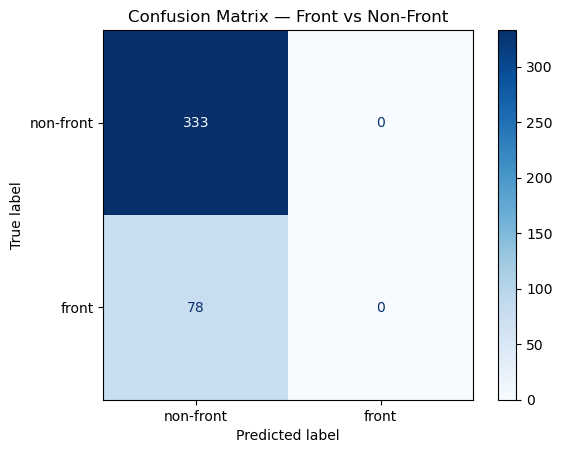

In [375]:
clf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['non-front','front']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['non-front','front'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Front vs Non-Front")
plt.show()

The accuracy ≈ 80 %, while this model is slightly better at detecting non-front than front (higher recall for non-front). The confusion matrix also shows balanced errors (no extreme bias).

Next, we’ll validate this performance with cross‐validation and then explore whether temporal smoothing (coarse‐binning) or dimensionality reduction can push accuracy even higher.

In [377]:
clf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_feat, y_front, cv=cv, scoring='accuracy', n_jobs=-1)

print("5-fold CV scores:", scores)
print("Mean CV accuracy:", scores.mean())

5-fold CV scores: [0.81508516 0.81995134 0.80243902 0.8        0.8097561 ]
Mean CV accuracy: 0.8094463236603169


This gave us a stable estimate over different splits of the data. We trained and tested the Random Forest five times, each on a different 80/20 split, and averaged the accuracies.

We consistently got scores in the 0.80s meaning that the folds are accurate and show reliability. 

### Research Question 2: classification results

### Classification using all features except feature engineered ones

In [381]:
# Step 1 Using simple training and testing, evaluate the models based on their accuracies using all the features except added ones.
label_encoder = LabelEncoder()
data = data.apply(label_encoder.fit_transform)

y = data['labels.person']
X = data.drop(['labels.person', 'activations_0_200', 'activations_200_400', 
               'total_activations', 'first_activation_time_frame', 'mean_activations'], axis=1)
X.columns

Index(['site_info.monkey', 'labels.stimID', 'labels.orientation',
       'labels.orient_person_combo', 'time.1_2', 'time.2_3', 'time.3_4',
       'time.4_5', 'time.5_6', 'time.6_7',
       ...
       'time.390_391', 'time.391_392', 'time.392_393', 'time.393_394',
       'time.394_395', 'time.395_396', 'time.396_397', 'time.397_398',
       'time.398_399', 'time.399_400'],
      dtype='object', length=403)

Accuracies (all features) using different models:
 {'Logistic Regression': 0.065625, 'KNN': 0.7125, 'Random Forest': 0.8875, 'AdaBoost': 0.084375}

-----------Using Logistic Regression for KFold----------


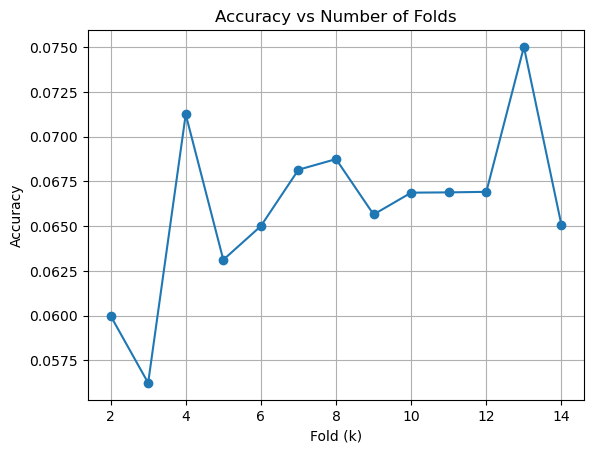


-----------Using KNN for KFold----------


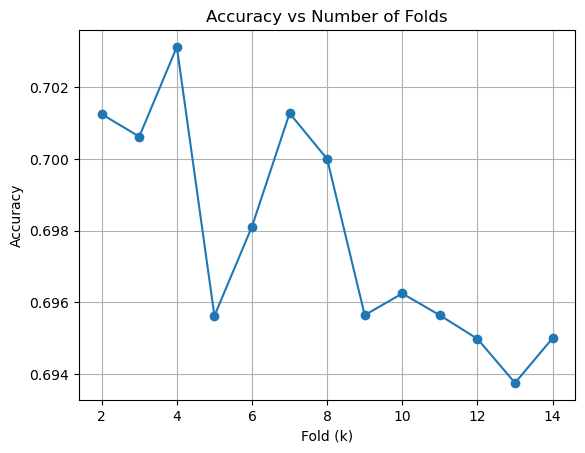


-----------Using Random Forest for KFold----------


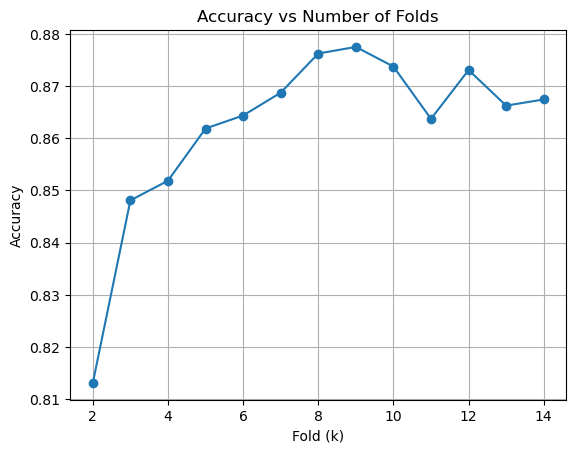


-----------Using AdaBoost for KFold----------


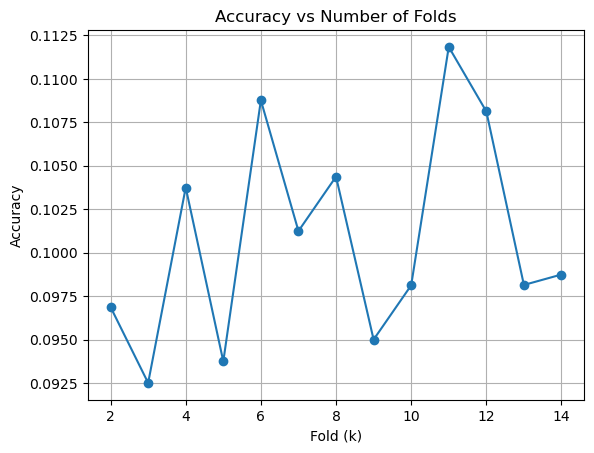

Using K-Fold - Best Accuracy and k values of models: results:
 {'Logistic Regression': (0.07501664346668281, 13), 'KNN': (0.703125, 4), 'Random Forest': (0.8775118672281117, 9), 'AdaBoost': (0.1118349293597286, 11)}


In [382]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {'Logistic Regression': LogisticRegression(max_iter=1000), 'KNN': KNeighborsClassifier(n_neighbors=1),
          'Random Forest': RandomForestClassifier(random_state=10),'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=10,
                                                                                                 algorithm="SAMME")}

results_no_added = train_test(models, X_scaled, y)
print(f'Accuracies (all features) using different models:\n {results_no_added}')

# Step 2 Use all the features except added features to perform K-Fold cross-validation to get the 
# best accuracies and k (fold value) across all models
results_no_added_cv = {}
for i, model in models.items():
    print(f'\n-----------Using {i} for KFold----------')
    best_acc, optimal_k = perform_KFold(model, X_scaled, y.values)
    results_no_added_cv[i] = (best_acc, optimal_k)

print(f'Using K-Fold - Best Accuracy and k values of models: results:\n {results_no_added_cv}')

In this case: 
- The Random Forest Classifier performs the best with an accuracy of 88.75% using single train test split.
- Cross validating the model, we see that Random forest classifier has the best accuracy of 87.775% with optimal k (fold value) of 9.

### Classification using all features including feature engineered ones

In [383]:
# Step 3 Using simple training and testing, evaluate the models based on their accuracies using all the features + added ones.
label_encoder = LabelEncoder()
data = data.apply(label_encoder.fit_transform)

y = data['labels.person']
X = data.drop(['labels.person'], axis=1)
X.columns

Index(['site_info.monkey', 'labels.stimID', 'labels.orientation',
       'labels.orient_person_combo', 'time.1_2', 'time.2_3', 'time.3_4',
       'time.4_5', 'time.5_6', 'time.6_7',
       ...
       'time.395_396', 'time.396_397', 'time.397_398', 'time.398_399',
       'time.399_400', 'activations_0_200', 'activations_200_400',
       'total_activations', 'first_activation_time_frame', 'mean_activations'],
      dtype='object', length=408)

Accuracies (all features) using different models:
 {'Logistic Regression': 0.06875, 'KNN': 0.709375, 'Random Forest': 0.690625, 'AdaBoost': 0.10625}

-----------Using Logistic Regression for KFold----------


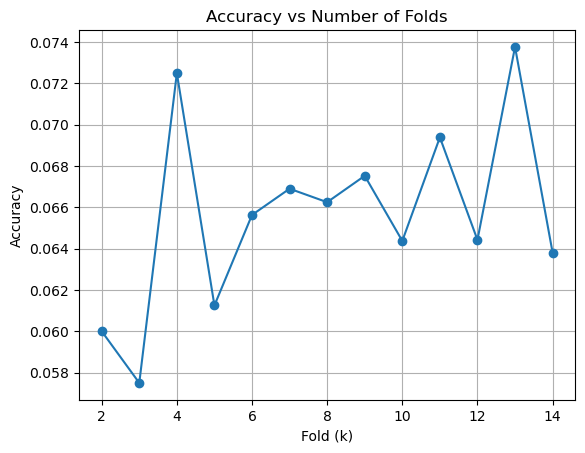


-----------Using KNN for KFold----------


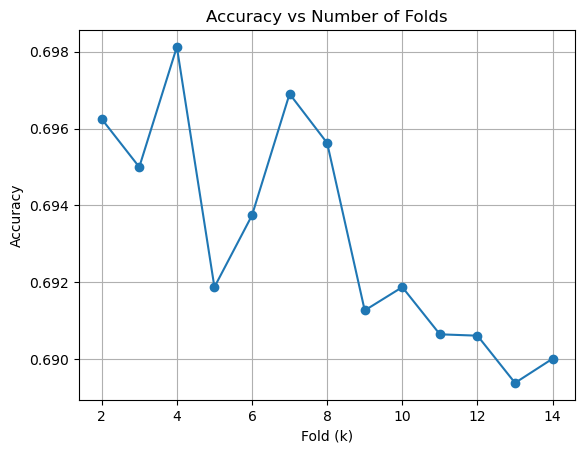


-----------Using Random Forest for KFold----------


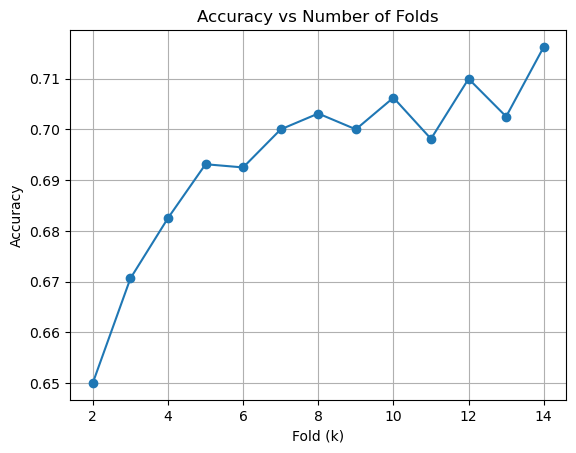


-----------Using AdaBoost for KFold----------


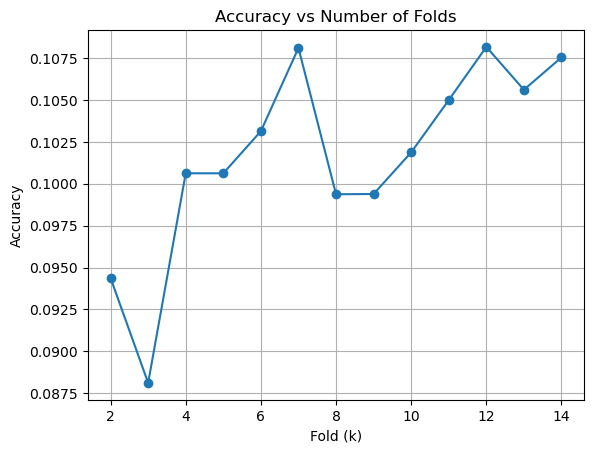

Using K-Fold - Best Accuracy and k values of models: results:
 {'Logistic Regression': (0.07377090520284856, 13), 'KNN': (0.6981249999999999, 4), 'Random Forest': (0.7162580363953361, 14), 'AdaBoost': (0.10816687240489282, 12)}


In [384]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {'Logistic Regression': LogisticRegression(max_iter=1000), 'KNN': KNeighborsClassifier(n_neighbors=1),
          'Random Forest': RandomForestClassifier(random_state=10),'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=10,
                                                                                                 algorithm="SAMME")}

results = train_test(models, X_scaled, y)
print(f'Accuracies (all features) using different models:\n {results}')

# Step 4 Use all the features + added features to perform K-Fold cross-validation to get the 
# best accuracies and k (fold value) across all models
results_cv = {}
for i, model in models.items():
    print(f'\n-----------Using {i} for KFold----------')
    best_acc, optimal_k = perform_KFold(model, X_scaled, y.values)
    results_cv[i] = (best_acc, optimal_k)

print(f'Using K-Fold - Best Accuracy and k values of models: results:\n {results_cv}')

In this case: 
- KNN performs the best with an accuracy of 70.937% using single train test split.
- Cross validating the model, we see that Random forest classifier has the best accuracy of 71.625.% with optimal k (fold value) of 14.

### Classification using Added Features (Without time interval neural activation features)

Accuracies (data without time neural activation features) using different models:
 {'Logistic Regression': 0.359375, 'KNN': 0.753125, 'Random Forest': 0.928125, 'AdaBoost': 0.171875}

-----------Using Logistic Regression for KFold----------


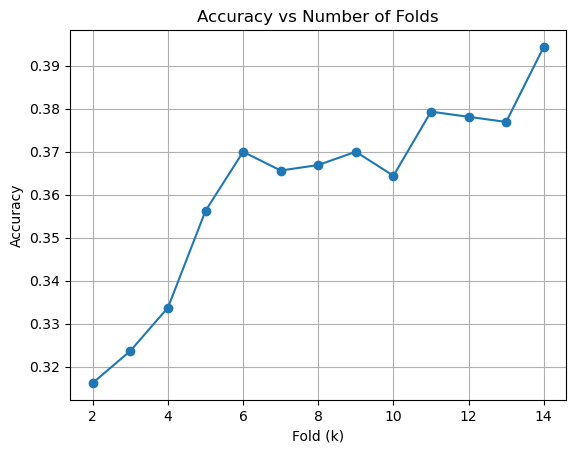


-----------Using KNN for KFold----------


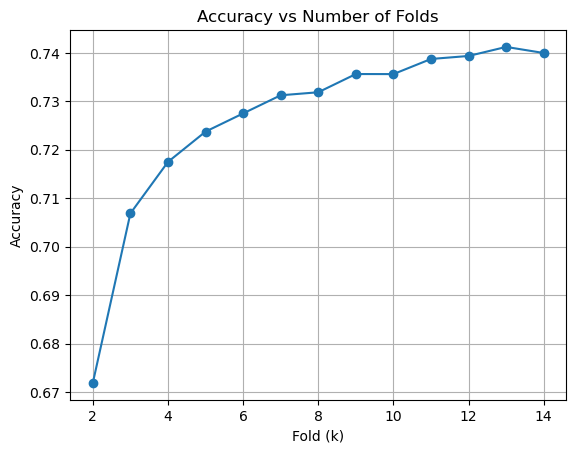


-----------Using Random Forest for KFold----------


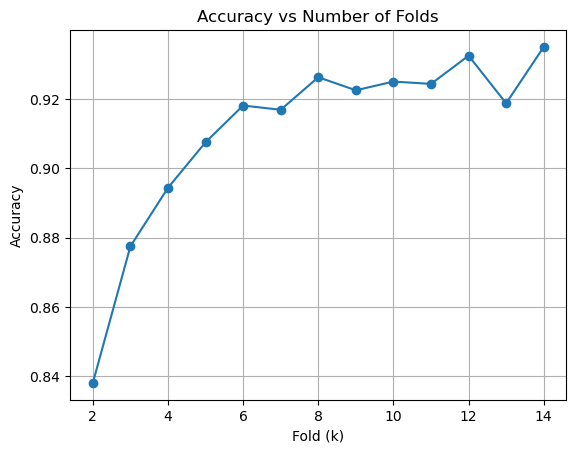


-----------Using AdaBoost for KFold----------


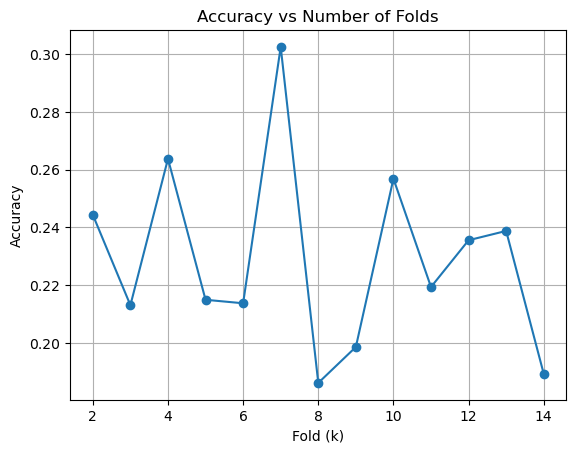

Using K-Fold (data without time neural activation features) - Best Accuracy and k values of models: results:
 {'Logistic Regression': (0.3943173150266972, 14), 'KNN': (0.741234440880389, 13), 'Random Forest': (0.9349841996295085, 14), 'AdaBoost': (0.3024373159974171, 7)}


In [386]:
# Step 5 Use the first five features and the newly introduced features (activations_0_200, activations_200_400, 
# total_activations, first_activation_time_frame, mean_activations) and repeat step 1.
y = data['labels.person']
X_selected = data.drop(data.iloc[:, 5:406], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

models = {'Logistic Regression': LogisticRegression(max_iter=1000), 'KNN': KNeighborsClassifier(n_neighbors=1),
          'Random Forest': RandomForestClassifier(random_state=10),'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=10,
                                                                                                 algorithm="SAMME")}

results_without_intervals = train_test(models, X_selected, y)
print(f'Accuracies (data without time neural activation features) using different models:\n {results_without_intervals}')

# Step 6 Using the features from step 5, repeat step 2. 
results_without_intervals_cv = {}
for i, model in models.items():
    print(f'\n-----------Using {i} for KFold----------')
    best_acc, optimal_k = perform_KFold(model, X_scaled, y.values)
    results_without_intervals_cv[i] = (best_acc, optimal_k)

print(f'Using K-Fold (data without time neural activation features) - Best Accuracy and k values of models: results:\n {results_without_intervals_cv}')

In this case: 
- The Random Forest Classifier performs the best with an accuracy of 92.812% using single train test split.
- Cross validating the model, we see that Random forest classifier has the best accuracy of 93.498% with optimal k (fold value) of 14.

### Classifcation with PCA 

Features reduced from 408 to 10
Accuracies (PCA on whole dataset + added features) using different models:
 {'Logistic Regression': 0.06875, 'KNN': 0.709375, 'Random Forest': 0.690625, 'AdaBoost': 0.10625}

-----------Using Logistic Regression for KFold----------


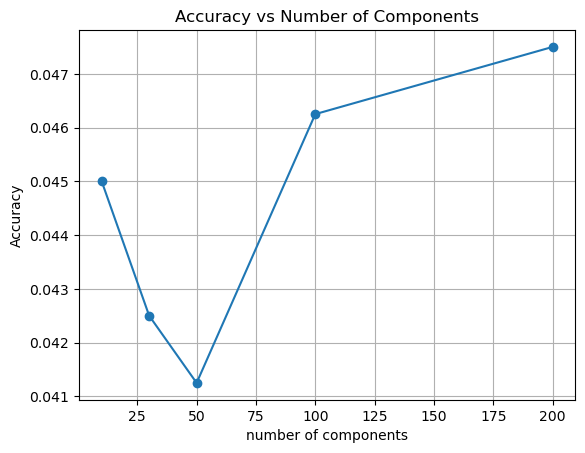


-----------Using KNN for KFold----------


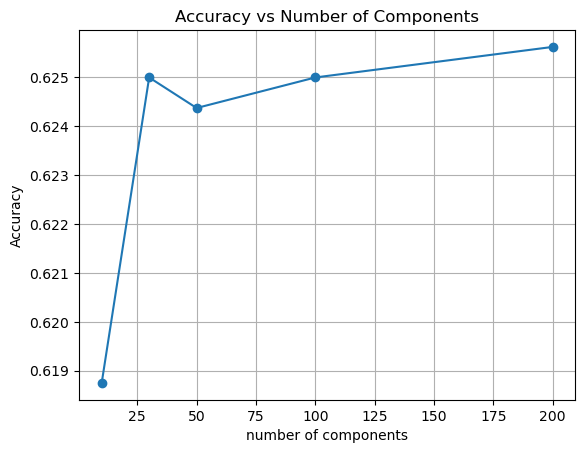


-----------Using Random Forest for KFold----------


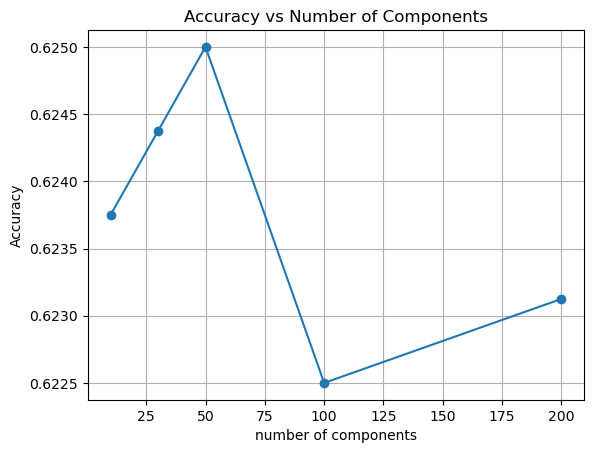


-----------Using AdaBoost for KFold----------


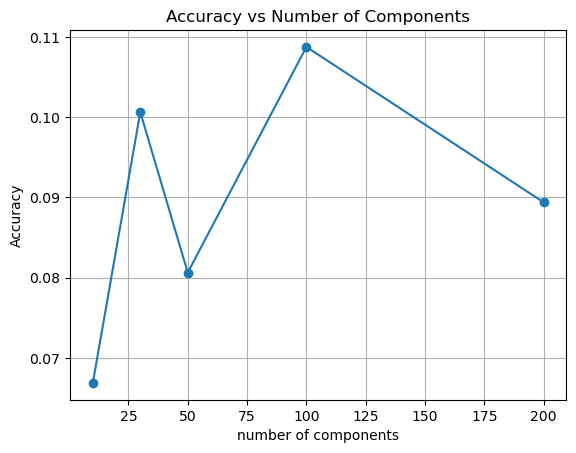

Using K-Fold (PCA on whole dataset + added features): Best Accuracy and k values of models: results:
 {'Logistic Regression': (0.0475, 200), 'KNN': (0.625625, 200), 'Random Forest': (0.625, 50), 'AdaBoost': (0.10875000000000001, 100)}


In [388]:
# Step 7 Use PCA (Principal Component Analysis) to reduce the number of features to 10 and evaluate the models based on accuracies. 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reduced_scaled = scaler.fit_transform(X_scaled)

pca = PCA(n_components=10)  
X_pca = pca.fit_transform(X_scaled)
print(f'Features reduced from {X.shape[1]} to {X_pca.shape[1]}')

results_pca = train_test(models, X_pca, y)
print(f'Accuracies (PCA on whole dataset + added features) using different models:\n {results_pca}')

# Step 8 Use K-Fold to obtain the best number of components and obtain the accuracies of the models along with 
# the optimal number of components.
results_pca_cv = {}
for i, model in models.items():
    print(f'\n-----------Using {i} for KFold----------')
    best_acc, optimal_n = perform_KFold_PCA(model, X_scaled, y.values, 5)
    results_pca_cv[i] = (best_acc, optimal_n)

print(f'Using K-Fold (PCA on whole dataset + added features): Best Accuracy and p values of models: results:\n {results_pca_cv}')

In this case: 
- KNN performs the best with an accuracy of 70.9375 using single train test split.
- Cross validating the models, we can see worse performance across all models. Random forest classifier has the best accuracy of 62.5% with optimal number of components used, 50.

### Comparing results

In [390]:
# Step 9 Compare results
model_names = []

no_pca_added_accs = []
no_pca_added_cv_accs = []

no_pca_accs = []
no_pca_cv_accs = []

pca_accs = []
pca_cv_accs = []

without_intervals_accs = []
without_intervals_cv_accs = []


for i, res in results_no_added.items():
    model_names.append(i)
    no_pca_added_accs.append(res)
    
for i, res in results_no_added_cv.items():
    no_pca_added_cv_accs.append(res[0])

for i, res in results.items():
    no_pca_accs.append(res)
    
for i, res in results_cv.items():
    no_pca_cv_accs.append(res[0])

for i, res in results_pca.items():
    pca_accs.append(res)

for i, res in results_pca_cv.items():
    pca_cv_accs.append(res[0])

for i, res in results_without_intervals.items():
    without_intervals_accs.append(res)

for i, res in results_without_intervals_cv.items():
    without_intervals_cv_accs.append(res[0])

    
temp_df = pd.DataFrame({'Model Name': model_names, 'All Features - Added': no_pca_added_accs, 'All Features - Added CV': no_pca_added_cv_accs,
                        'All Features + Added': no_pca_accs, 'All Features + Added CV': no_pca_cv_accs,
                        'Only Added Features': selected_accs, 'Only Added Features CV': selected_cv_accs,
                        'PCA (n=10)': pca_accs, 'PCA CV (best n)': pca_cv_accs})
temp_df

,Model Name,All Features - Added,All Features - Added CV,All Features + Added,All Features + Added CV,Only Added Features,Only Added Features CV,PCA (n=10),PCA CV (best n)
0,Logistic Regression,0.065625,0.075017,0.068750,0.073771,0.359375,0.394317,0.068750,0.047500
1,KNN,0.712500,0.703125,0.709375,0.698125,0.753125,0.741234,0.709375,0.625625
2,Random Forest,0.887500,0.877512,0.690625,0.716258,0.928125,0.934984,0.690625,0.625000
3,AdaBoost,0.084375,0.111835,0.106250,0.108167,0.171875,0.302437,0.106250,0.108750


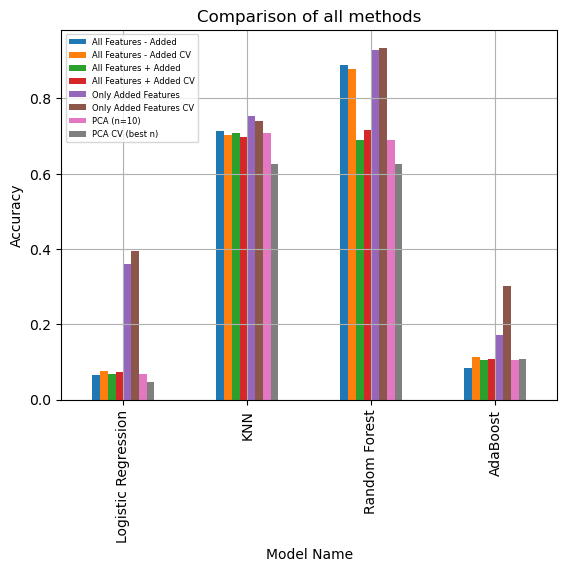

In [391]:
temp_df.plot(kind='bar', x='Model Name')
plt.ylabel('Accuracy')
plt.title('Comparison of all methods')
plt.grid(True)
plt.legend(fontsize=6, loc='upper left')
plt.show()

The graph shows several things:

- Models using the engineered (added) features always perform better than when they aren't used. Specifcally 
- Performing cross-validation with engineered features almost always performs better than the other methods
- Random forest classifier and KNN are superior to logistic regression and AdaBoost. Random Forest achieves up to 93.4% accuracy adn KNN achieves up to 75.3% while Logistic Regression achieves up to 39.4% and AdaBoost 30.2%
- Cross-validating the random forest model using K-Fold using selected features performs the best out of every other model and method with an accuracy of 93.4%. 


### Hyperparameter tuning for the best model

In [456]:
# Step 10 Using the best model obtained through accuracies, 
# find the best hyperparameter for that model and evaluate results.
# Random Forest is deemed the best model the best accuracy using the the newly created features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=10)

param_grid = {'n_estimators': [10, 30, 50, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30, 50],
              'min_impurity_decrease': [0.0, 0.01, 0.1, 0.5], 
             }

# Using the optimal k value obtained when cross validating random forest classifier
grid = GridSearchCV(models['Random Forest'], param_grid, cv=14, scoring='accuracy')
grid.fit(X_train, y_train)

print(f'Best Parameters are {grid.best_params_}')

best_model = grid.best_estimator_

y_hat = best_model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print(f'Accuracy: {acc}')
print(f'Classification report: \n: {classification_report(y_test, y_hat)}')

Best Parameters are {'criterion': 'entropy', 'max_depth': None, 'min_impurity_decrease': 0.0, 'n_estimators': 100}
Accuracy: 0.9375
Classification report: 
:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.92      0.96        12
           2       0.88      1.00      0.93         7
           3       0.92      1.00      0.96        12
           4       1.00      0.95      0.97        20
           5       1.00      1.00      1.00         9
           6       0.89      1.00      0.94         8
           7       0.71      0.92      0.80        13
           8       1.00      0.69      0.81        16
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        12
          12       0.92      1.00      0.96        24
          13       1.00      0.85      0.92        13
          14       0.76      1.

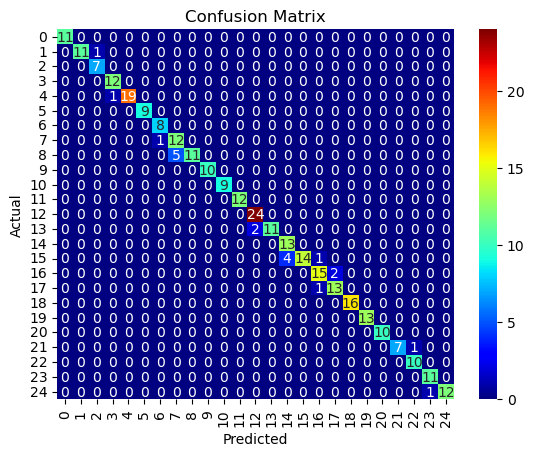

In [457]:
sns.heatmap(confusion_matrix(y_test, y_hat), cmap='jet', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We obtain an accuracy of 93.75% using the best hyperparameters obtained for Random Forest. The heatmap shows a good amount of correct classifications for all 25 labels.person (0-24). Person label 12 shows the most correct classifications (24) followed by label 4 and 17. Person label 7 shows the most misclassifications (5).

## Discussion and Conclusion

## Discussion and Conclusion

### Research Question 1

Part of our goal was to determine how well the AM face‐patch population activity can tell whether a viewed face is head‐on (“front”) versus any other orientation (“non‐front”). Our findings show a test accuracy of 80%, precision/recall for “front” views: 0.83/0.75, precision/recall for “non‐front” views: 0.78/0.85, and finally a 5-fold CV accuracy of around 80%, showcasing this models reliability. 

These results show that AM carries a strong, easily decodable signal for frontal face presentations—far above chance (50 %) and tightly consistent across data splits.



### Research Question 2

We can conclude that the models perform better with the engineered features. These features help the models generalize the time interval features more effectively and by removing noisy time interval features, we observe improvements in model performance. Additionally, we find that the Random Forest Classifier achieves the highest accuracy across all models and methods used. When retrained and tested with the best hyperparameters, the Random Forest Classifier achieved an accuracy of 93.75%, outperforming both the model without the best parameters and the cross-validation results, which showed the highest accuracy of 93.4%.

## Future Work

### Research Question 1:

Some of the obstacles that we ran into include high feature dimensionalty, working with 400 time bins could result in overfitting, yet the random forrest was able to pick up a clear signal. Having an equal number of front vs. non-front views would also be more beneifical to see how the data stacks up against each other. Next, we might use bins (e.g. 20–40 bins) to reduce noise and potentially boost accuracy above 80 % or we might compare to gradient‐boosting or SVM to see if non‐tree models capture frontal signals differently.

### Research Question 2:

We utilized just one csv file (1600, 806) which was subsequently reduced to (1600, 409). Unfortunately the code takes 
~2-3 minutes to complete. We hope to optimize our code, specifically the cross-validation part, which performs poorly (in terms of computational efficiency) when its performed on Random Forest and AdaBoost. Making better additional features to capture the time features and making use of more models (Neural Networks, SVCs) may lead us to obtaining a better model and results. 

We were unable to utilize LOOCV (runtime ~30-45 minutes) due to the high-dimensionality of our dataset. As a result, we couldn't compare its performance with K-Fold. In the future, we plan to explore advanced sampling techniques and also address potential duplicates that may exist in our dataset.

## Author contribution

- Tyler worked on research question 1, slides, project template and the video.
- Sukruth worked on research question 2, slides, project template and the video

## References

Freiwald, W. A., & Tsao, D. Y. (2010). Functional compartmentalization and viewpoint generalization within 
the macaque face-processing system. Science, 330(6005), 845-851.

https://medium.com/data-science/adaboost-classifier-explained-a-visual-guide-with-code-examples-fc0f25326d7b#:~:text=AdaBoost%20is%20an%20ensemble%20machine,importance%20to%20previously%20misclassified%20examples.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/

https://medium.com/@datasciencewizards/understanding-the-adaboost-algorithm-2e9344d83d9b#:~:text=Talking%20about%20the%20main%20idea,one%20strong%20machine%2Dlearning%20model.